In [31]:
import numpy as np 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [12]:
data = np.load('part1a.npz')
data.files

['N', 'Svc_0_pmf', 'Lc', 'Ic_0', 'gamma']

In [13]:
# Total population, N.
N = data['N']
# Everyone else, S0, is susceptible to infection initially.
S = data['Svc_0_pmf'] * data['N']
# Initial number of infected and recovered individuals, I0 and R0.
I = data['Ic_0']
R = 0
# Contact rate: beta, mean recovery rate: gamma (in 1/days).
gamma = data['gamma']
beta = np.linspace(0.1,0.3,16).reshape(4,4) # arbitrary non-decreasing beta values
L = data['Lc']

t = (0, 120)

In [14]:
def SIR(t, y, L, N, beta, gamma):
    '''Must solve 4 Ic in order to solve 1 Svc. Must 
    solve 4 Svc in order to solve 1 Ic. Must solve 4 Ic in order to solve
    1 R. Must solve 4 Ic to solve 1  L.'''
    S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = y

    dS00dt = -beta[0,0] * S00 * I0 / N
    dS10dt = -beta[1,0] * S10 * I0 / N
    dS20dt = -beta[2,0] * S20 * I0 / N
    dS30dt = -beta[3,0] * S30 * I0 / N
    
    dS01dt = -beta[0,1] * S01 * I0 / N
    dS11dt = -beta[1,1] * S11 * I0 / N
    dS21dt = -beta[2,1] * S21 * I0 / N
    dS31dt = -beta[3,1] * S31 * I0 / N
    
    dS02dt = -beta[0,2] * S02 * I0 / N
    dS12dt = -beta[1,2] * S12 * I0 / N
    dS22dt = -beta[2,2] * S22 * I0 / N
    dS32dt = -beta[3,2] * S32 * I0 / N

    dS03dt = -beta[0,3] * S03 * I0 / N
    dS13dt = -beta[1,3] * S13 * I0 / N
    dS23dt = -beta[2,3] * S23 * I0 / N
    dS33dt = -beta[3,3] * S33 * I0 / N
    
    dI1dt = -1 * np.sum([dS00dt,dS10dt,dS20dt,dS30dt]) - (gamma * I1)
    dI2dt = -1 * np.sum([dS01dt,dS11dt,dS21dt,dS31dt]) - (gamma * I2)
    dI3dt = -1 * np.sum([dS02dt,dS12dt,dS22dt,dS32dt]) - (gamma * I3)
    dI4dt = -1 * np.sum([dS03dt,dS13dt,dS23dt,dS33dt]) - (gamma * I4)
    dIdt = np.sum([dI1dt, dI2dt, dI3dt, dI4dt]) 
    
    dRdt = gamma * I0
    
#     print(f'dSdt = {dSdt}\n')
#     print(f'dIdt = {dIdt}\n')
#     print(f'dRdt = {dRdt}\n')
    
    return dS00dt, dS01dt, dS02dt, dS03dt,\
    dS10dt,dS11dt,dS12dt,dS13dt, \
    dS20dt,dS21dt,dS22dt, dS23dt, \
    dS30dt,dS31dt,dS32dt,dS33dt, \
    dI1dt, dI2dt, dI3dt, dI4dt, \
    dIdt, dRdt

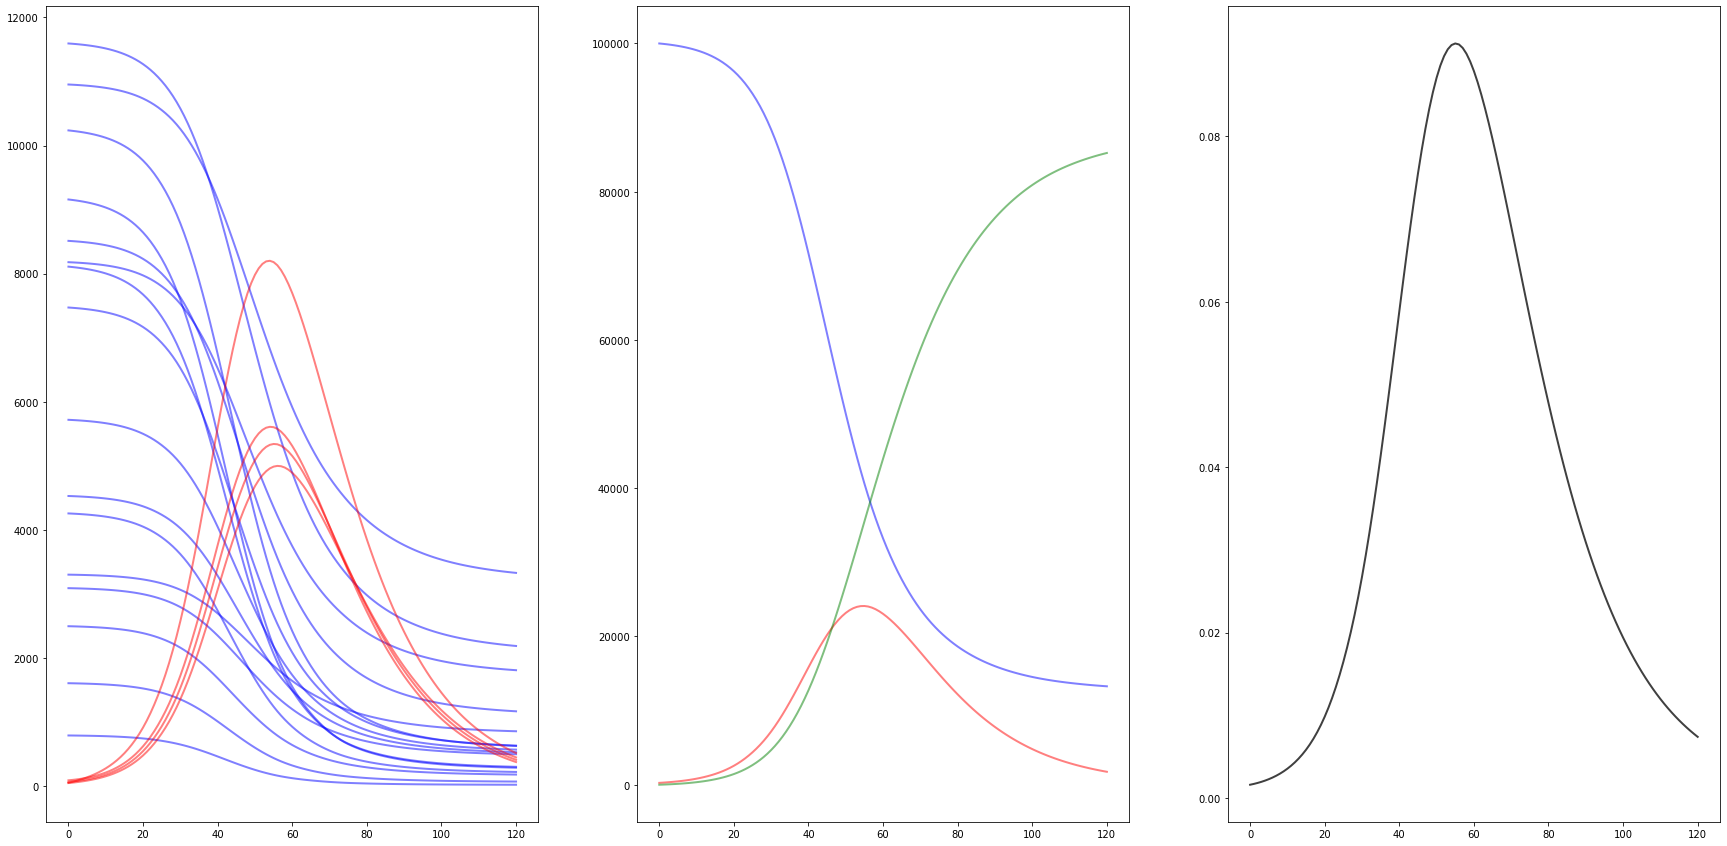

In [15]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (30,15) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
all_I = [I1,I2,I3,I4]
# Plot viral load density L
Lty = (I1 * L[0] + I2 * L[1] + I[3] * L[2] + I4 * L[3])/N
ax[2].plot(soln.t, Lty, 'black', alpha = 0.75, lw = 2, label = 'Viral Load Density')
# Plot Susceptible vc
for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

# Plot # Infected vc
for Ic in all_I:
    ax[0].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

# Plot Overall S, I, R
ax[1].plot(soln.t, np.sum(all_S, axis = 0), 'b', alpha=0.5, lw=2, label='Susceptible')
ax[1].plot(soln.t, np.sum(all_I, axis = 0),'r', alpha=0.5, lw=2, label='Infected')
ax[1].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

# Proportion of susceptible people who never were infected

In [203]:
for i, Svc in enumerate(all_S):
    #print(f"i: {i}, Svc[-1]: {Svc[-1]}, Svc[0]: {Svc[0]}\n")
    print(f"Proportion {i}: {Svc[-1]/Svc[0]}")

Proportion 0: 0.30385930986884385
Proportion 1: 0.25925183318555345
Proportion 2: 0.22116861930870635
Proportion 3: 0.18864642323700023
Proportion 4: 0.16086522528162292
Proportion 5: 0.13712696724770584
Proportion 6: 0.11683742143621478
Proportion 7: 0.09949073472600328
Proportion 8: 0.08465625641671017
Proportion 9: 0.07196731535123997
Proportion 10: 0.06111166046891348
Proportion 11: 0.05182332054652795
Proportion 12: 0.043875674474910344
Proportion 13: 0.037075553858456
Proportion 14: 0.03125822575595577
Proportion 15: 0.02628312563766615


# 6.

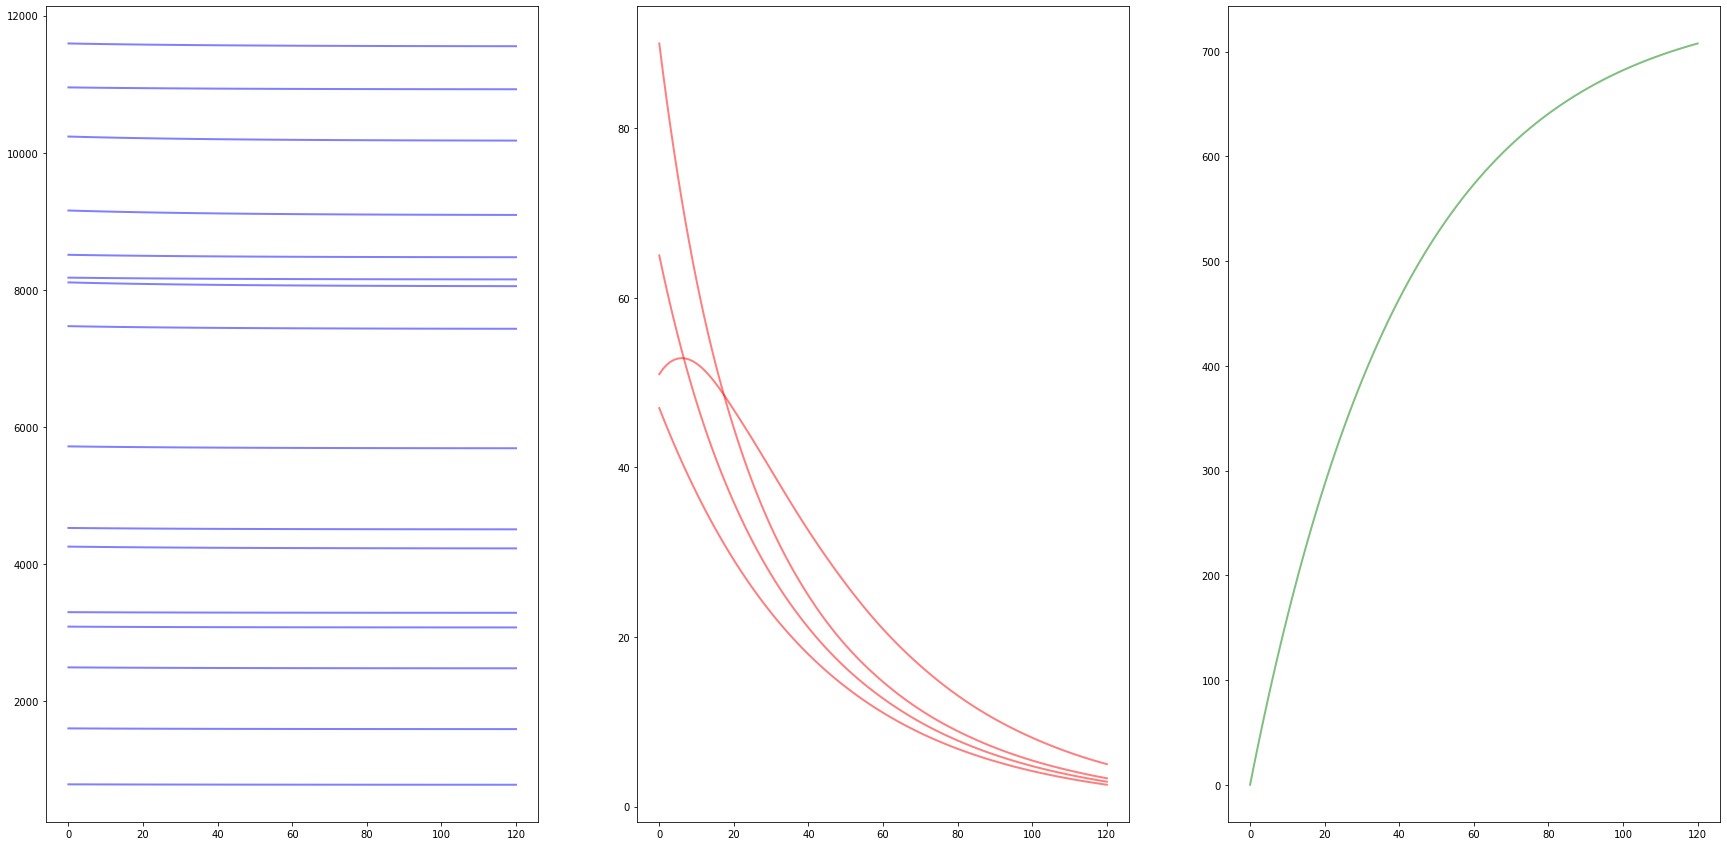

In [191]:
fig, ax = plt.subplots(1, 3, sharex = True, figsize = (30,15) )
# ax[0].set(xlabel = "t (Time in days)", ylabel = "Number",
#          title = "SIR Curve")
soln = solve_ivp(SIR, t, y0 = (S[0,0],S[0,1],S[0,2],S[0,3],
                               S[1,0],S[1,1],S[1,2],S[1,3],
                               S[2,0],S[2,1],S[2,2],S[2,3],
                               S[3,0],S[3,1],S[3,2],S[3,3],
                               I[0],I[1],I[2],I[3], I.sum(), R), 
                 dense_output = True, t_eval=np.arange(121),\
                 args = (L, N, beta/4, gamma) )
S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33, \
    I1, I2, I3, I4, \
    I0, R0 = soln.y

all_S = [S00, S01, S02, S03,\
    S10,S11,S12,S13, \
    S20,S21,S22, S23, \
    S30,S31,S32,S33]
for Svc in all_S:
    ax[0].plot(soln.t, Svc, 'b', alpha=0.5, lw=2, label='Susceptible')

for Ic in [I1,I2,I3,I4]:
    ax[1].plot(soln.t, Ic, 'r', alpha=0.5, lw=2, label='Infected')

ax[2].plot(soln.t, R0, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

In [113]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
# fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
# ax.set_xlabel('Time /days')
# ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
# plt.show()

## Part 1b

In [4]:
bdata = np.load("part1b.npz")

In [5]:
bdata.files

['N', 'Lc', 'Ic_0', 'gamma', 'L_validation', 'L_test', 'betas_validation']

In [17]:
N_b = bdata['N'] # Each node has population N
L_b = bdata['Lc']
I_b = bdata['Ic_0']
gamma_b = bdata['gamma']
L_validation = bdata['L_validation']
L_test = bdata['L_test']
betas_validation = bdata['betas_validation']

How to calculate L for part 1b:
- for beta_grid in beta_grid_hypothesis_space:
    - use _integrate.solve_ivp()_
    - 

In [58]:
def SIR_b(t, y, N, beta, gamma):
    
    Sv0, Sv1, Sv2, Sv3, I0, I1, I2, I3, I = y

    dSv0dt = -beta[0] * Sv0 * I / N
    dSv1dt = -beta[1] * Sv1 * I / N
    dSv2dt = -beta[2] * Sv2 * I / N
    dSv3dt = -beta[3] * Sv3 * I / N
    
    dI0dt = -1 * dSv0dt - (gamma * I0)
    dI1dt = -1 * dSv1dt - (gamma * I1)
    dI2dt = -1 * dSv2dt - (gamma * I2)
    dI3dt = -1 * dSv3dt - (gamma * I3)
    
    dIdt = np.sum([dI0dt, dI1dt, dI2dt, dI3dt]) 
    
#     print(f'dSdt = {dSdt}\n')
#     print(f'dIdt = {dIdt}\n')
#     print(f'dRdt = {dRdt}\n')
    
    return dSv0dt, dSv1dt, dSv2dt, dSv3dt,\
    dI0dt, dI1dt, dI2dt, dI3dt, \
    dIdt

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from itertools import product
from time import time

beta_grid=np.linspace(0,1,21)
mmse=np.inf
beta_mmse=np.nan

pmf0c = np.array([0.5,0.3,0.1,0.1])
Sv0, Sv1, Sv2, Sv3 = pmf0c * 50000 * 4
I0,I1,I2,I3 = np.sum(I_b[:5], axis = 0)
I_five_nodes = np.sum([I0,I1,I2,I3])

start = time()
# Part 1b grid search for optimal values of beta over first 5 nodes of vulnerability 0,2
for (betav0, betav1, betav2, betav3) in product(beta_grid, beta_grid, beta_grid, beta_grid):
    if betav0 <= betav1 <= betav2 <= betav3:
        beta = [betav0, betav1, betav2, betav3]
#         soln_obj = solve_ivp(SIR_b, t_span = (0,19), 
#                              y0 = (Sv0, Sv1, Sv2, Sv3,
#                              I0,I1,I2,I3, I_five_nodes), 
#                              t_eval = np.arange(20),
#                              args = (N_b, beta, gamma_b))

        soln_obj = solve_ivp(SIR_b, t_span = (0,19), \
                             y0 = (Sv0, Sv1, Sv2, Sv3,
                             I0,I1,I2,I3, I_five_nodes), \
                             t_eval = np.arange(20), dense_output = True, \
                             args = (N_b, beta, gamma_b))
        
        Sv0_y, Sv1_y, Sv2_y, Sv3_y, I0_y, I1_y, I2_y, I3_y, I_nodes = soln_obj.y
        L_sample = np.sum(np.array([I0_y * L_b[0], I1_y * L_b[1],I2_y * L_b[2],I3_y * L_b[3]]), axis = 0)/250000
        mse = mean_squared_error(np.sum(L_validation[:5], axis = 0)/250000, L_sample) 

        if mse < mmse:
            mmse = mse
            beta_mmse = beta
end = time()
print(f"Run time: {end - start:.2f} seconds")
print(f"Estimated values are beta={beta_mmse}")

Run time: 98.39
Estimated values are beta=[0.0, 0.05, 0.05, 0.1]


In [26]:
I0,I1,I2,I3 = np.sum(I_b[:5], axis = 0)
print(I0,I1,I2,I3)

238 276 301 251


In [29]:
from itertools import product
for i in product(np.arange(5),np.arange(5),np.arange(5),np.arange(5)):
    print(i)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 0, 2, 2)
(0, 0, 2, 3)
(0, 0, 2, 4)
(0, 0, 3, 0)
(0, 0, 3, 1)
(0, 0, 3, 2)
(0, 0, 3, 3)
(0, 0, 3, 4)
(0, 0, 4, 0)
(0, 0, 4, 1)
(0, 0, 4, 2)
(0, 0, 4, 3)
(0, 0, 4, 4)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 1, 2, 2)
(0, 1, 2, 3)
(0, 1, 2, 4)
(0, 1, 3, 0)
(0, 1, 3, 1)
(0, 1, 3, 2)
(0, 1, 3, 3)
(0, 1, 3, 4)
(0, 1, 4, 0)
(0, 1, 4, 1)
(0, 1, 4, 2)
(0, 1, 4, 3)
(0, 1, 4, 4)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 2, 0)
(0, 2, 2, 1)
(0, 2, 2, 2)
(0, 2, 2, 3)
(0, 2, 2, 4)
(0, 2, 3, 0)
(0, 2, 3, 1)
(0, 2, 3, 2)
(0, 2, 3, 3)
(0, 2, 3, 4)
(0, 2, 4, 0)
(0, 2, 4, 1)
(0, 2, 4, 2)
(0, 2, 4, 3)
(0, 2, 4, 4)
(0, 3, 0, 0)
(0, 3, 0, 1)

In [71]:
np.sum(L_validation[:5], axis = 0)/250000

array([0.00257984, 0.00270963, 0.00284992, 0.00298888, 0.00316408,
       0.00335872, 0.00353037, 0.0037541 , 0.00399272, 0.00420527,
       0.00446045, 0.00479409, 0.00506757, 0.00538994, 0.0057208 ,
       0.00610884, 0.00647007, 0.00693861, 0.00733771, 0.00787633])

In [75]:
beta_mmse

[0.0, 0.05, 0.1, 0.15000000000000002]

In [76]:
beta_grid

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])